In [525]:
##from https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py


from __future__ import print_function, division

import matplotlib.pyplot as plt

import numpy as onp

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform


from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline



# Using an RDF as a scoring function. 

An EDM could come from points in many dimensions, so it's possible that there are multiple weird ways to satisfy any given EDM. These ways would all be consistent with other EDMs, and so the network will be happy, but the actual 3D realisation of those EDMs might _do not_ work how we expect. 

Alternatively, if we directly learn 3D coordinates, and then compare the euclidean distances to a known distribution, then the network is forced to make the distances consistent with what we expect in 3D space. Put another way, the network can't just put all atoms at the same distance as a carbon-carbon bond distance, because there is not enough volume in 3d dimensions to fit all the atoms surrounding the central atom. The surrounding atoms will thus be forced to move outwards, and hopefully it all settles on a reasonable-looking molecule.  

The below fits a loss function using the distributions of known atom distances. 

The network part uses JAX numpy, hence the original numpy is re-nicknamed `onp`.

In [2]:
##load dataset of QM9 isomers. 
mols = list()
smiles = [i.strip('\n') for i in open('larger_dataset.smi', 'r').readlines()]
for smi in smiles:
    mols.append(Chem.MolFromSmiles(smi))

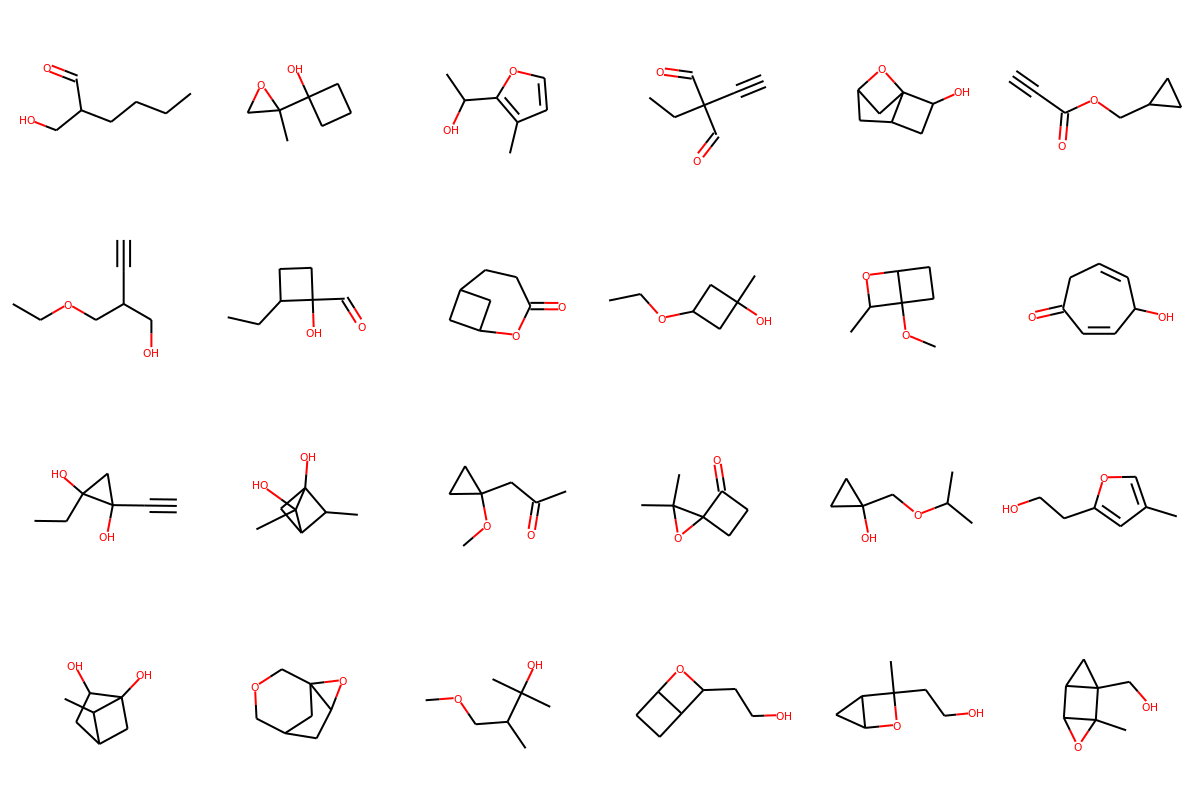

In [3]:
###draw sample
Draw.MolsToGridImage(onp.random.choice(onp.array(mols), 24), molsPerRow=6)


In [4]:
###Calculates 3d coordinates of a molecule using RDKit, and then gets a euclidean distance matrix. 
def getEDM(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None
    
##Less necessary here, but keeping it around as it may be used later. 
##This permutes the indices of the atoms so you don't always have 
##sequental atoms bonded to each other - the 'bonded' distances in the EDM
##should be able to appear anywhere on the board. 
def permute_edm(edm, atom_identities, num_permutes=1000):
    edm= squareform(edm)
    idx = onp.arange(9)
    edm_list = list()
    atom_list = list()
    
    for _ in range(num_permutes):
        onp.random.shuffle(idx)
        edm_copy = edm[idx][:,idx]
        edm_list.append(squareform(edm_copy))
        atom_list.append(atom_identities[idx])
    return edm_list, atom_list

In [5]:
###Run through molecules and make the EDM dataset. 
edms = list()
atomidx = list()
for count, m in enumerate(onp.random.choice(onp.array(mols), 2000)):
    print(count, end='\r')
    points = getEDM(m)
    if points is None:
        None
    else:
        edm = pdist(points)
        atoms = onp.clip(onp.array([i.GetAtomicNum() for i in m.GetAtoms()])-7, 0, 1)
        el, al = permute_edm(edm, atoms, num_permutes=10)
        for e, a in zip(el, al):
            edms.append(e)
            atomidx.append(a)

# Radial Distribution Function

This is the same as a histogram of the pairwise euclidean distances. It plots the density of expected distances. As seen below, there are a number of peaks, which we can probably assign to (left to right) directly bonded atoms (about 1.3 angstrom), atoms separated by one bond (2-3A), atoms separated by two bonds, etc... 

Text(0, 0.5, 'Density')

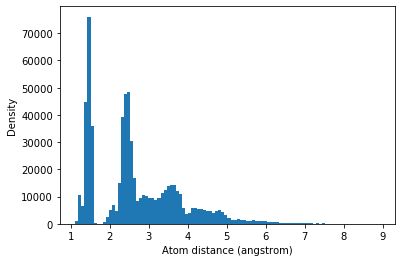

In [566]:
edms = onp.array(edms)
#_ = plt.hist(edms.flatten(), bins=100)
_ = plt.hist(edms.reshape(-1,1), bins=100)
plt.xlabel('Atom distance (angstrom)')
plt.ylabel('Density')

# Fitting the RDF with a Gaussian Mixture Model

This is a perfect use-case for a gaussian mixture model. Sklearn is fine. Currently fitting with four components because that seems to get the majority of the density, but larger number of components may be better. 

In [52]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, covariance_type='spherical')

gmm.fit(edms.flatten().reshape(-1,1))

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

### plot to show how the fit is:
Plot the individual components found by sklearn. 
The true density function is a sum of these components.

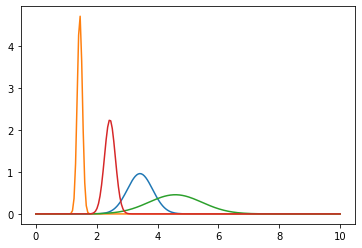

In [567]:
def gaussian(w, x, mu, sig):
    return w*(onp.exp(-(x - mu)**2 / (2 * sig**2)))

x = onp.linspace(0, 10, 200)

##Calculating gaussian heights using the weights from sklearn GMM:
amplitudes = list()
for m, c, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    gauss = gaussian(w, x, m, onp.sqrt(c))
    amplitudes.append(1/ onp.trapz(gauss, x) * w )

##Plot individual components as a sanity check.
for m, c, w in zip(gmm.means_, gmm.covariances_, amplitudes):
    plt.plot(x, gaussian(w, x, m, onp.sqrt(c)))
    


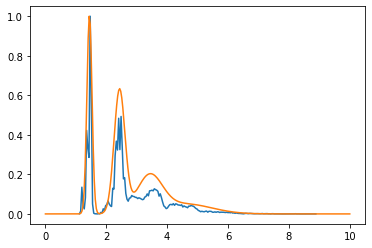

In [568]:
###Just for fun, plot with scipy.stats norm as well:

from scipy.stats import norm
rvs = list()
for j,k in zip(gmm.means_, gmm.covariances_):
    rv = norm(j, onp.sqrt(k))
    rvs.append(rv)
    
    
hist,edges = onp.histogram(edms.reshape(-1,1), bins=200)
plt.plot(edges[:-1], hist/np.max(hist), label='Real')
x = np.linspace(0,10,300)
y = [np.sum([rv.pdf(v)*w for rv, w in zip(rvs, gmm.weights_)]) for v in x]
plt.plot(x,y/onp.max(y), label='Fitted')

# Can we turn this into a loss function? 

The below just takes the inverse of the gaussians found by the GMM as the loss. This means points in an area of low-density will have larger loss, encouraging all points to be at suitable distances (i.e. high density regions of the GMM). 

In [569]:
#print out values to put into loss function below:
print(gmm.means_, gmm.covariances_**0.5, amplitudes)

[[3.42311921]
 [1.44627436]
 [4.58541227]
 [2.43398331]] [0.41530006 0.08399728 0.87352645 0.17758828] [0.9606121464196986, 4.749466517754573, 0.4567031851461081, 2.2464449222574374]


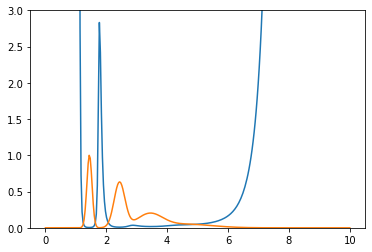

In [585]:
####possibly the hill inbetween 1-bond and 2-bonded atoms is too high to cross? 
def loss(x):
    loss = 1/ (50*(gaussian(0.960, x, 3.42, 0.415)+\
            gaussian(4.749,  x, 1.44, 0.0839)+\
            gaussian(0.456,  x, 4.58, 0.873)+\
            gaussian(2.246,  x, 2.43, 0.177)))
    return loss

plt.plot(x, loss(x))
plt.ylim(0,3)
plt.plot(x,y/onp.max(y))

# Can we use this loss function in a neural net?

Using jax.stax here for the net. The idea is to generate coordinates from noise (i.e. latent coordinates like a GAN or a VAE) and to take the loss function as defined above (i.e. the inverse of the gmm density)

The code below borrows from two good examples:


There is a great tutorial for doing this: MAML with JAX: https://github.com/ericjang/maml-jax/blob/master/maml.ipynb with more depth explanation at: https://blog.evjang.com/2019/02/maml-jax.html

However some of the code is old. So, also using: https://github.com/google/jax/blob/master/examples/mnist_vae.py which seems more similar to the current task but has no explanation. 

In [601]:
import jax.numpy as np
from jax.config import config
from jax import jit, grad, lax, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, FanOut, Relu, Softplus

In [602]:
##Functions to calculate pairwise distances between atoms, 
##and to calculate loss from proposed coordinates. 
##the loss takes coordinates, gets a distance matrix, 
##takes the upper triangle (no repeats needed), 
##and then sums the loss of them. 
@jit
def pairwise_distances(xyz1, xyz2):
    d0 = np.abs(xyz1[:,0].reshape([-1,1]) - xyz2[:,0])
    d1 = np.abs(xyz1[:,1].reshape([-1,1]) - xyz2[:,1])
    d2 = np.abs(xyz1[:,2].reshape([-1,1]) - xyz2[:,2])
    return d0+d1+d2

@jit
def loss(p, noise):
    coords = decode(p, noise).reshape(9,3)
    distance_matrix = pairwise_distances(coords, coords)
    distances = distance_matrix[np.triu_indices(9,1)]
    loss = np.sum(1/ (30*(gaussian(0.960, distances, 3.42, 0.415)+\
            gaussian(4.749,  distances, 1.44, 0.0839)+\
            gaussian(0.456,  distances, 4.58, 0.873)+\
            gaussian(2.246,  distances, 2.43, 0.177))))
    return loss

#new gaussian with jax.np
@jit
def gaussian(w, x, mu, sig):
    return w*(np.exp(-(x - mu)**2 / (2 * sig**2)))

In [614]:
##Get a random number generator:
test_rng = random.PRNGKey(1)
#Google used an encoder AND a decoder in the jax example. I just want one, hence the _ 
_, dec_init_rng = random.split(random.PRNGKey(2))

##Not sure a large network is needed. Might play with latent_dims and activation functions.
decoder_init, decode = stax.serial(
    Dense(256), Relu,
    Dense(256), Relu,
    Dense(27),
)

latent_dims=10
batch_size=4
step_size = 0.001
num_epochs = 100

##Using variable batch dimension at the moment (hence size is (-1, latent_dims))
_, init_decoder_params = decoder_init(dec_init_rng, (-1, latent_dims))

#opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=0.9)
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(init_decoder_params)

In [619]:

def step(i, opt_state, key):
    key, noise_key = random.split(key)
    noise = random.normal(noise_key, shape=(1, latent_dims))
    p = get_params(opt_state)
    
    g = grad(loss)(p, noise)
    print(loss(p, noise))
    return opt_update(i, g, opt_state)

In [620]:
##Training part:

key = random.PRNGKey(1)
for i in tqdm_notebook(range(2000)):
    opt_state = step(i, opt_state, key)



/home/lewis/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


335832.8
49520.754
2684.659
214.37712
12.160713
7.2109942
386.80115
87.68527
484.23044
205.14442
337.91
87.8023
85.560265
106.12338
289.04626
60.54182
9.574413
8.1722355
2.616592
5.9322186
605.75964
25.54391
5.683671
12.579847
42.821453
177.13028
307.3009
67.39586
41.478714
683.7601
36.50849
46.320282
475.82053
150.47072
13.137382
434.95547
10.411638
8.029402
931.66455
52.767124
680.3653
74.59764
374.69302
58.787254
40.025337
28.636019
26.414165
30.109844
36.036507
40.281334
40.47003
38.52157
36.93943
29.268
19.310349
12.8595295
8.489687
5.6420164
5.6816473
4.2277594
3.1041756
2.7591891
2.4809957
2.2693958
2.1304226
2.0473661
2.004978
1.9838336
1.9876065
2.0340226
2.113092
2.110649
1.9720962
1.8306603
1.7416239
1.6881298
1.6523021
1.6258633
1.6046531
1.5862513
1.5664008
1.5469296
1.5282743
1.5107464
1.4955711
1.4831843
1.4714344
1.4572849
1.4403286
1.4227085
1.4060677
1.3905494
1.3752323
1.3589519
1.341851
1.3259356
1.3147677
1.3080878
1.3026094
1.2953309
1.2865623
1.2783353
1.2717685


1.124929
1.1249261
1.1249232
1.1249201
1.1249171
1.1249143
1.1249115
1.1249084
1.1249056
1.1249028
1.1249001
1.1248972
1.1248946
1.1248918
1.1248889
1.124886
1.1248833
1.1248806
1.1248779
1.1248751
1.1248726
1.1248698
1.1248671
1.1248646
1.1248618
1.1248593
1.1248567
1.1248541
1.1248515
1.1248488
1.1248465
1.1248438
1.1248415
1.124839
1.1248363
1.1248337
1.1248314
1.1248288
1.1248266
1.124824
1.1248218
1.124819
1.1248169
1.1248144
1.1248119
1.1248097
1.1248072
1.124805
1.1248026
1.1248003
1.124798
1.1247959
1.1247935
1.1247911
1.124789
1.1247867
1.1247845
1.1247823
1.1247799
1.1247778
1.1247758
1.1247735
1.1247714
1.1247692
1.1247671
1.1247649
1.1247628
1.1247606
1.1247586
1.1247565
1.1247544
1.1247523
1.1247503
1.1247482
1.1247463
1.1247442
1.124742
1.1247401
1.1247382
1.1247362
1.1247344
1.1247321
1.1247303
1.1247284
1.1247264
1.1247244
1.1247225
1.1247206
1.1247187
1.1247169
1.1247151
1.1247131
1.1247113
1.1247092
1.1247075
1.1247058
1.1247039
1.124702
1.1247003
1.1246984
1.1246965


1.1244049
1.1244048
1.1244049
1.1244049
1.1244049
1.1244048
1.1244049
1.1244049
1.1244049
1.1244049
1.1244048
1.1244048
1.1244049
1.1244049
1.1244049
1.1244048
1.1244048
1.1244049
1.1244048
1.1244049
1.1244048
1.1244048
1.1244049
1.1244049
1.1244049
1.1244048
1.1244048
1.1244049
1.1244049
1.1244048
1.1244049
1.1244048
1.1244049
1.1244047
1.1244048
1.1244049
1.1244048
1.1244047
1.1244048
1.1244049
1.1244047
1.1244049
1.1244048
1.1244048
1.1244049
1.1244049
1.1244047
1.1244047
1.1244047
1.1244049
1.1244049
1.1244049
1.1244049
1.1244047
1.1244048
1.1244047
1.1244048
1.1244047
1.1244048


KeyboardInterrupt: 

# How does it look?

Predict some coordinates and plot to see if they are at least consistent with the expected radial distribution function. 

In [621]:
key, noise_key = random.split(key)
noise = random.normal(noise_key, shape=(latent_dims,))
p = get_params(opt_state)
coords = decode(p, noise).reshape(9,3)
distance_matrix = pairwise_distances(coords, coords)
distances = distance_matrix[np.triu_indices(9,1)]

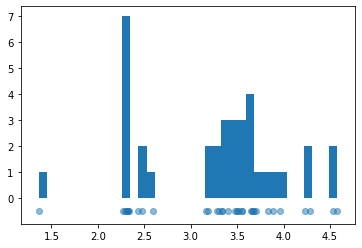

In [622]:
plt.hist(distances, bins=36)
plt.scatter(distances, np.zeros(len(distances))-0.5, alpha=0.5)

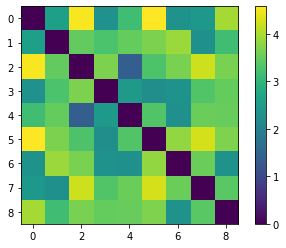

In [623]:
edm = squareform(distances)
plt.imshow(squareform(distances))
plt.colorbar()

In [624]:
def to_M_matrix(D):
    D1j = np.tile(D[0, :], len(D)).reshape(D.shape)
    Di1 = D1j.T
    return .5 * (-D + D1j + Di1)

def setPositions(mol_in, coords):
    conformer = mol_in.GetConformer(0)
    for i in range(mol_in.GetNumAtoms()):
        x,y,z = coords[i]
        conformer.SetAtomPosition(i,Point3D(x,y,z))
    return mol_in

D = edm**2
M = to_M_matrix(D)
S, U = np.linalg.eigh(M)

coord = np.matmul(U, np.diag(np.sqrt(np.abs(S))))
X = coord[:, -3:]


In [629]:
def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#"+str(atomicNumList[0])+"]")
    rwMol = Chem.RWMol(mol)
    for i in range(1,len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)

    mol = rwMol.GetMol()

    return mol


def xyz2AC(atomicNumList,xyz):
    import numpy as np
    mol = get_proto_mol(atomicNumList)

    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i,(float(xyz[i][0]),float(xyz[i][1]),float(xyz[i][2])))
    mol.AddConformer(conf)

    dMat = Chem.Get3DDistanceMatrix(mol)
    pt = Chem.GetPeriodicTable()

    num_atoms = len(atomicNumList)
    AC = np.zeros((num_atoms,num_atoms)).astype(int)

    for i in range(num_atoms):
        a_i = mol.GetAtomWithIdx(i)
        Rcov_i = pt.GetRcovalent(a_i.GetAtomicNum())*1.50
        for j in range(i+1,num_atoms):
            a_j = mol.GetAtomWithIdx(j)
            Rcov_j = pt.GetRcovalent(a_j.GetAtomicNum())*1.50
            if dMat[i,j] <= Rcov_i + Rcov_j:
                AC[i,j] = 1
                AC[j,i] = 1

    return AC,mol


In [630]:
atomicNumList = [6]*9
#for i in atomidentities:
#    if i<0.0:
#        atomicNumList.append(6)
#    else:
#        atomicNumList.append(8)
#atomicNumList= [6]*9

am, mol =xyz2AC(atomicNumList,X)

In [631]:

eMol = Chem.EditableMol(mol)

bonds = np.triu(am)
for j, k in zip(onp.where(bonds)[0], onp.where(bonds)[1]):
    print(j,k)
    try:
        eMol.AddBond(int(j),int(k))
    except:
        None

1 7
2 4
2 5
3 4
4 5
4 6


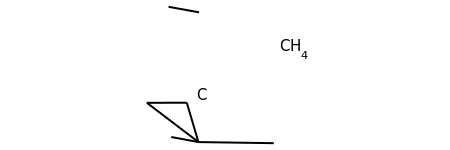

In [632]:
mol = eMol.GetMol()

Chem.rdmolfiles.MolToPDBFile(mol, 'tempmol.pdb', flavor=0)
mol

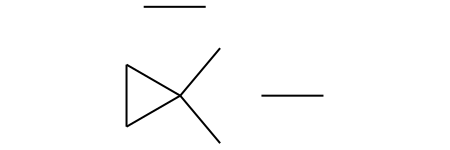

In [537]:
mol.Compute2DCoords()
mol